In [2]:
%matplotlib notebook

In [3]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [4]:
register_matplotlib_converters()

<IPython.core.display.Javascript object>


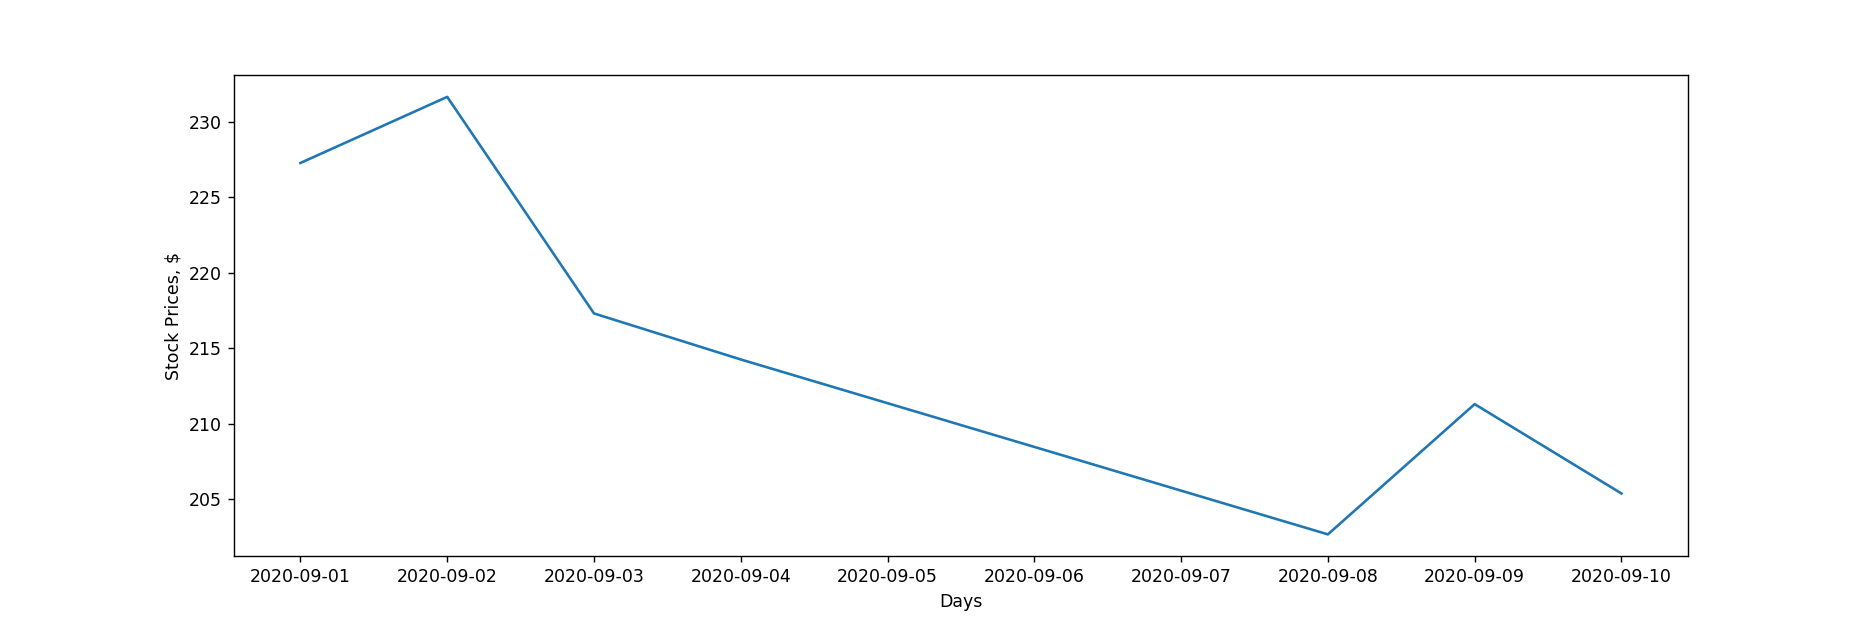

In [173]:
#Extracting data using webreaders
#Need to predict stocks from 9/28/2020
start = datetime.datetime(2020,9,1)
end = datetime.datetime(2020,9,10)
prices = web.DataReader("MSFT", 'yahoo', start, end).reset_index(drop = False)[['Date', 'Close']]

plt.figure(figsize = (15,5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, $')
plt.show()

In [174]:
#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

start_date = '2020-09-01'
end_date = '2020-09-10'
pred_end_date = '2020-10-5'

In [163]:
returns = (prices.loc[1:, 'Close'] - \
          prices.shift(1).loc[1:, 'Close']) / \
          prices.shift(1).loc[1:, 'Close']
print(returns.tolist())

[0.014814289764672526, -0.032897953481874694, -0.012711252347248302, -0.02399414776883687, 0.019412381951731374, -0.017572237335490036, -0.002020655590480467]


In [175]:
# Paramter Assignments
So = prices.loc[prices.shape[0] - 1, "Close"]
dt = 1 #day # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays # days  # User input -> follows from pred_end_date
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}


In [176]:
# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

[-0.00801687 -0.01603375 -0.02405062 -0.03206749 -0.04008437 -0.04810124
 -0.05611811 -0.06413499 -0.07215186 -0.08016873 -0.08818561 -0.09620248
 -0.10421935 -0.11223623 -0.1202531  -0.12826997 -0.13628685]
{'1': array([ 0.00122327,  0.03751277,  0.03083244,  0.0473339 ,  0.02325612,
        0.05872246,  0.06458099,  0.0886107 ,  0.07331399,  0.06029741,
        0.0378946 ,  0.009962  ,  0.00723436,  0.00994364,  0.04933631,
        0.00923941, -0.00096486]), '2': array([ 0.02652009,  0.01325676,  0.02569039,  0.02722476,  0.04448607,
        0.05800684,  0.07695056,  0.0721656 ,  0.06351476,  0.07744092,
        0.07351478,  0.06249454,  0.05489209,  0.02046582,  0.03360784,
       -0.00500966, -0.00974756]), '3': array([-0.00415554, -0.00075174, -0.01372236, -0.00307122, -0.01082132,
        0.02602654,  0.02449665,  0.0533588 ,  0.07523871,  0.08410658,
        0.11329149,  0.13714449,  0.15472661,  0.147843  ,  0.1388802 ,
        0.14904928,  0.17572608]), '4': array([ 0.01712383

In [177]:
# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
print(S[1])

[205.36999512 209.20537535 204.80047693 205.70703115 204.37784717
 206.27596601 207.41441802 209.69323094 207.02588183 203.60383287
 204.81054773 202.37904212 198.56276857 195.4854494  187.36204158
 188.32476511 179.74399198 177.4659567 ]


<IPython.core.display.Javascript object>


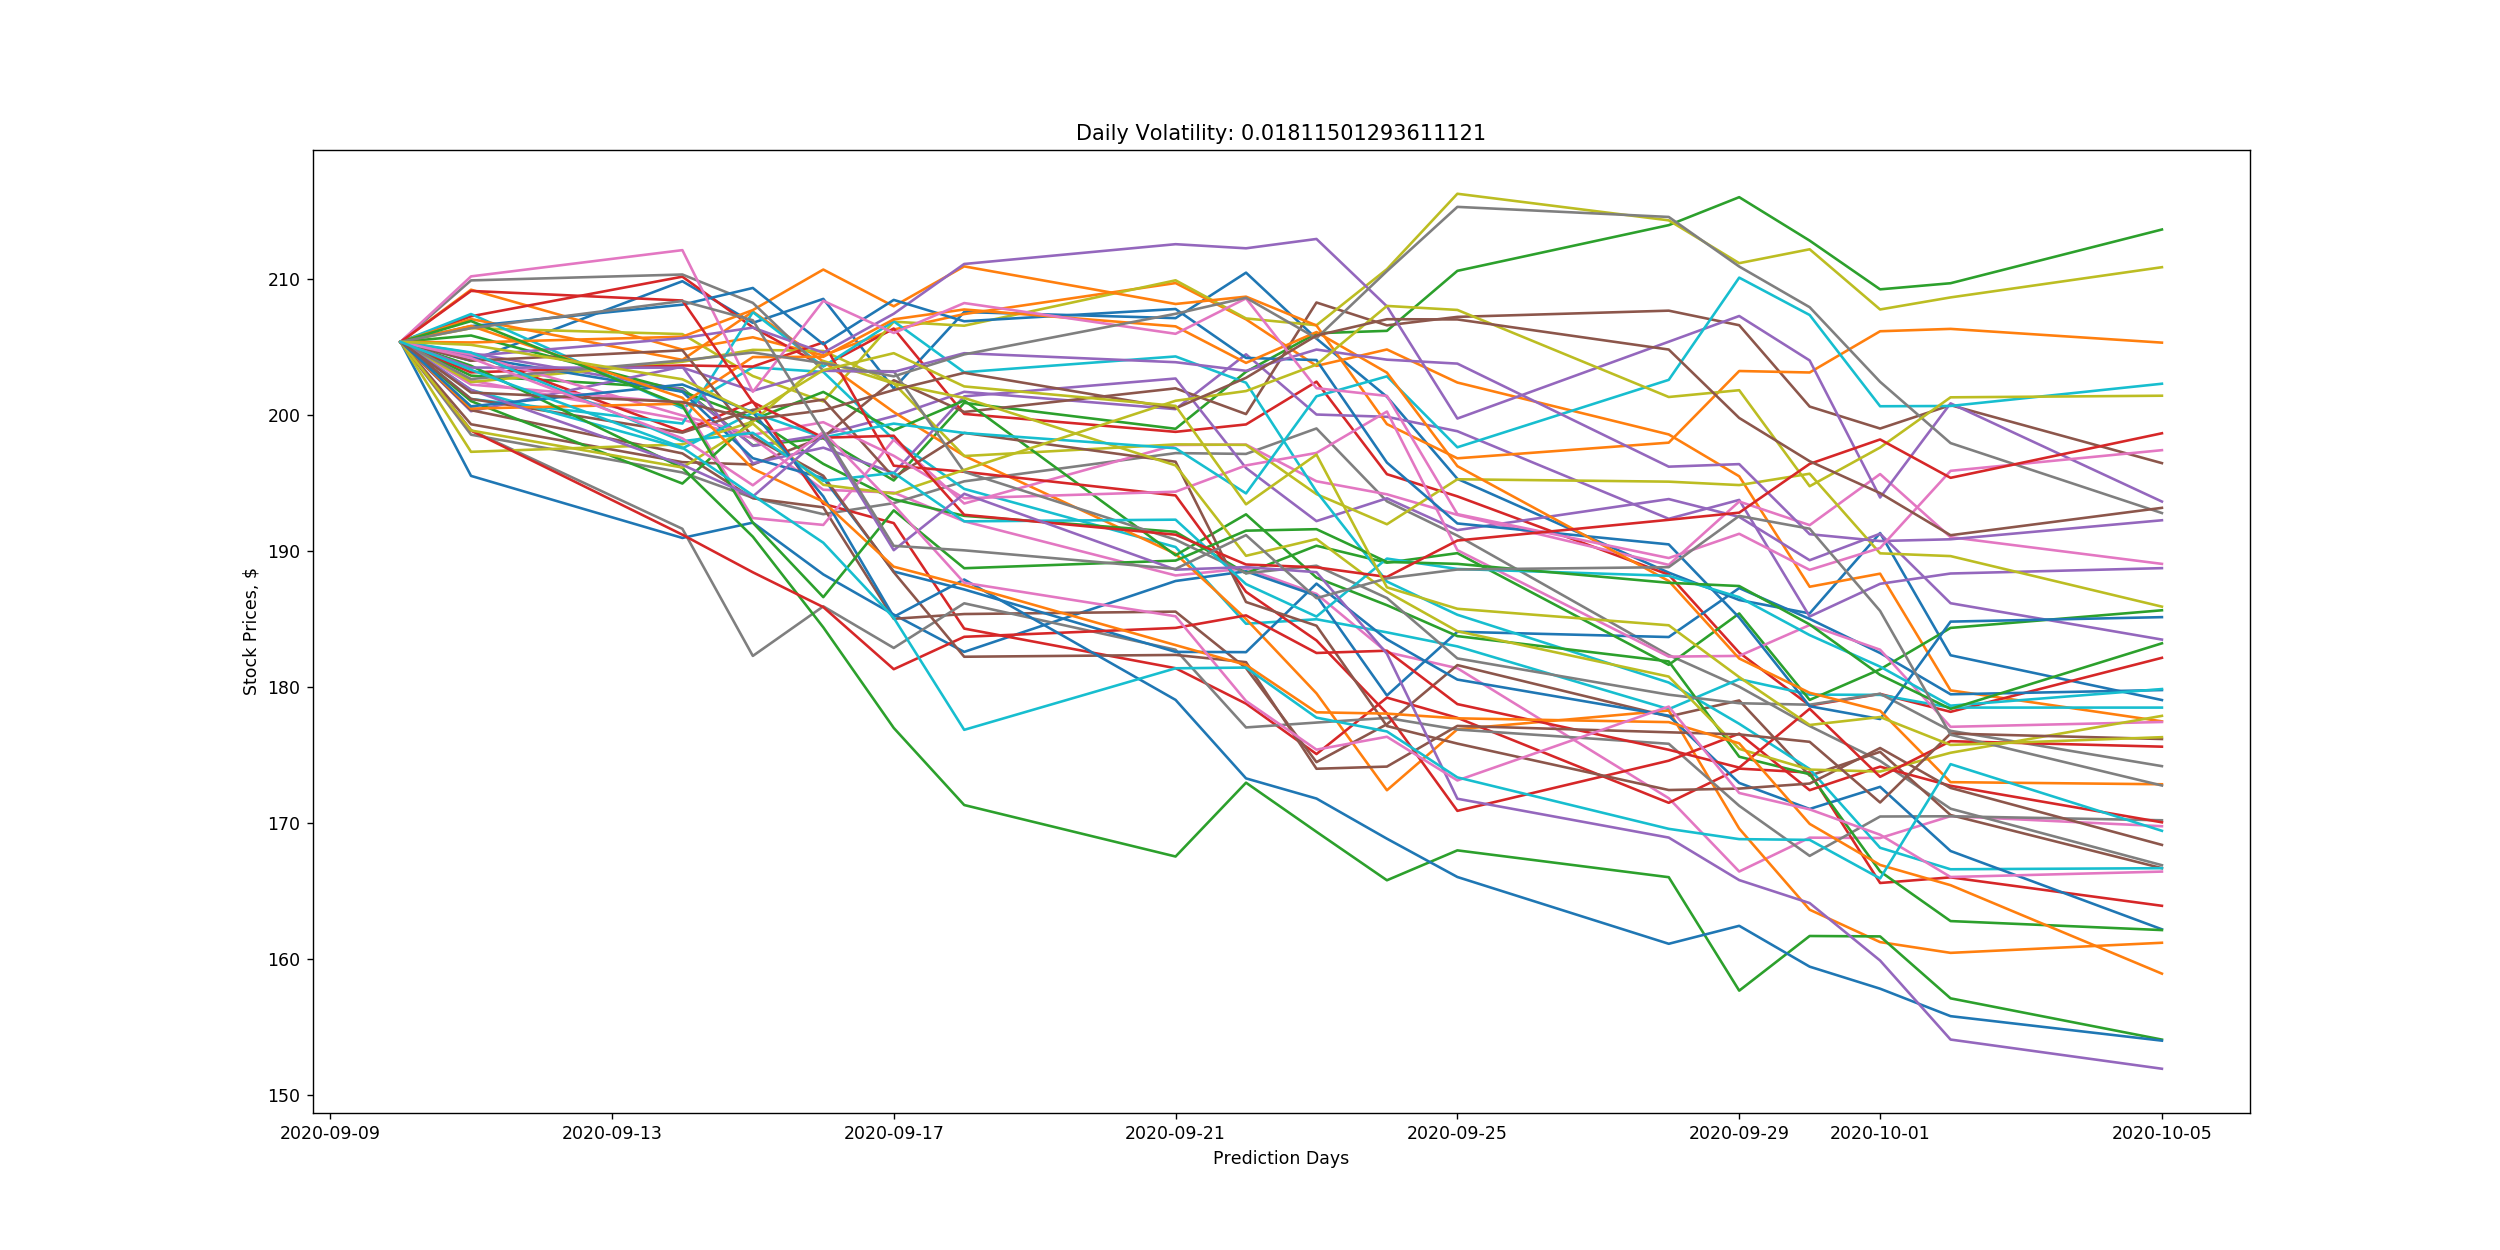

In [178]:
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = prices["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, $')
    plt.xlabel('Prediction Days')
plt.show()

In [15]:
# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = prices["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)
print(Preds_df)

        index           0           1           2           3           4  \
0  2020-09-10  205.369995  205.369995  205.369995  205.369995  205.369995   
1  2020-09-11  201.601017  211.667767  202.743261  203.259629  197.700190   
2  2020-09-14  202.090730  198.808770  201.135075  219.838985  202.137270   
3  2020-09-15  199.836435  192.640326  177.625890  219.703511  192.852026   
4  2020-09-16  190.044058  190.567356  179.700234  221.746623  187.834385   
5  2020-09-17  194.912367  195.335682  175.972246  217.824132  196.513573   
6  2020-09-18  192.037423  190.942027  166.591647  216.765692  198.654722   
7  2020-09-21  196.629247  199.873876  164.413816  212.895263  193.880952   
8  2020-09-22  196.317907  199.619505  160.270989  213.289920  195.405080   
9  2020-09-23  184.044599  189.056503  157.919426  224.828390  198.353534   
10 2020-09-24  179.458156  181.981658  157.952505  224.549019  192.562212   
11 2020-09-25  174.241582  186.924401  157.207587  224.471689  180.837746   

In [179]:
#Test against actual graph
check_start = datetime.datetime(2020,9,10)
check_end = datetime.datetime(2020,9,28)
check_prices = web.DataReader("MSFT", 'yahoo', check_start, check_end).reset_index(drop = False)[['Date', 'Close']]

In [180]:
def compute_differences(pred, actual):
    sum = 0
    for i in range(len(actual)):
        temp_min = abs(pred[i] - actual[i])
        sum += temp_min
    return sum

In [181]:
min_sum = 10000000
actual_array = check_prices.loc[:, 'Close']
index = -1
for i in range(len(check_prices)):
    pred_date_to_check = S[i][:19]
    sum = compute_differences(pred_date_to_check, actual_array)
    if sum < min_sum:
        min_sum = sum
        index = i
        print(index)

0
1


<IPython.core.display.Javascript object>


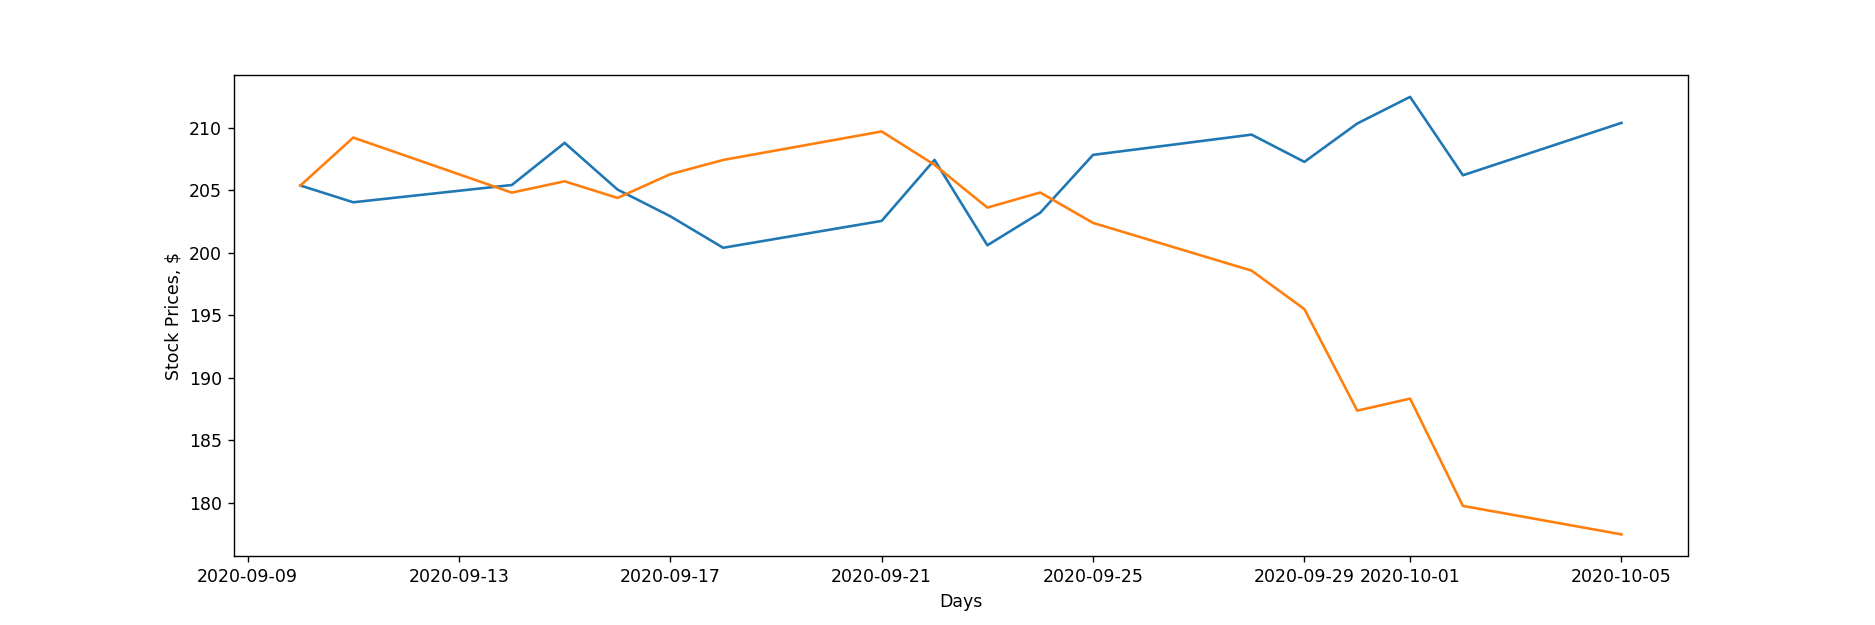

In [183]:
#dummy data
dummy_start = datetime.datetime(2020,9,10)
dummy_end = datetime.datetime(2020,10,5)
dummy_prices = web.DataReader("MSFT", 'yahoo', dummy_start, dummy_end).reset_index(drop = False)[['Date', 'Close']]
plt.figure(figsize = (15, 5))
plt.plot(dummy_prices['Date'], dummy_prices['Close'])
plt.plot(dummy_prices['Date'], S[index])
plt.xlabel('Days')
plt.ylabel('Stock Prices, $')
plt.show()